**Este archivo contiene el modelo de Regresión que usa XGBoost para la predicción de Hembras Ovigeras**

**Las variables predictoras consideradas fueron:**

**Variables Cuantitativas:**

Semana

Año

Temperatura

Salinidad

Prom. Adultos Móviles

Prom. Juveniles


**Variables Categóricas:**

Región

ACS

Especie


In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
#DATASET

df = pd.read_excel('Archivo_Unificado_Limpio.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180175 entries, 0 to 180174
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Código Centro            180175 non-null  int64  
 1   semana                   180175 non-null  int64  
 2   Año                      180175 non-null  int64  
 3   Región                   180175 non-null  object 
 4   ACS                      180175 non-null  object 
 5   Especie                  180175 non-null  object 
 6   Prom. Hembras Ovígeras   180175 non-null  float64
 7   Prom. Adultos Móviles    180175 non-null  float64
 8   Prom. Juveniles          180175 non-null  float64
 9   Prom. Parásitos Totales  180175 non-null  float64
 10  Temperatura              180175 non-null  float64
 11  Salinidad                180175 non-null  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 16.5+ MB


In [ ]:
#Modelado usando XGBOOST
target = 'Prom. Hembras Ovígeras'
features = [
    'Prom. Juveniles',
    'Prom. Adultos Móviles',
    'Temperatura',
    'Salinidad',
    'Región',
    'ACS',  
    'Especie',
    'semana',
    'Año'
]

X = df[features]
y = df[target]

# 3. Codificación One-Hot para variables categóricas con pocas categorías
cat_vars = ['Región', 'Especie']
X_encoded = pd.get_dummies(X, columns=cat_vars, drop_first=True)

# (Opcional) Codificar ACS si decides incluirlo. Si no, puedes eliminarlo:
X_encoded = X_encoded.drop(columns=['ACS'])  # si no quieres usarlo

# 4. División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, shuffle=True, stratify=None
)

# 5. Entrenamiento del modelo
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=1,
    min_child_weight=2,
    random_state=42
    
)
model.fit(X_train, y_train)

# 6. Predicción y evaluación
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" RMSE: {rmse:.3f}")
print(f" R²: {r2:.3f}")

📊 RMSE: 1.631
📈 R²: 0.798


In [ ]:
#ENTRENAMMIENTO CON GRIDSEARCH Y PIPELINE
target = 'Prom. Hembras Ovígeras'
features = [
    'Prom. Juveniles',
    'Prom. Adultos Móviles',
    'Temperatura',
    'Salinidad',
    'Región',
    'Especie',
    'ACS',
    'semana',
    'Año'
]

X = df[features]
y = df[target]

# Identificar variables categóricas y numéricas
cat_vars = ['Región', 'Especie', 'ACS']
num_vars = [col for col in X.columns if col not in cat_vars]

# Pipeline: transformación y modelado
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_vars)
    ],
    remainder='passthrough'  # deja las columnas numéricas como están
)

# Modelo base
xgb_model = XGBRegressor(random_state=42)

# Pipeline con preprocesamiento + modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

# Hiperparámetros a buscar
param_grid = {
    'regressor__n_estimators': [100, 300, 500],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [4, 6, 8],
    'regressor__subsample': [0.7, 0.8, 1],
    'regressor__colsample_bytree': [0.8, 1],
    'regressor__gamma': [0, 1],
    'regressor__reg_alpha': [0, 0.1],
    'regressor__reg_lambda': [1, 2],
    'regressor__min_child_weight': [1, 2, 5]
}

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Entrenar
grid_search.fit(X_train, y_train)

# Predicción y evaluación
y_pred = grid_search.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" Mejor combinación de hiperparámetros: {grid_search.best_params_}")
print(f" RMSE: {rmse:.3f}")
print(f" R²: {r2:.3f}")

In [ ]:
# Convertir los resultados a DataFrame ordenado por mejor score (menor RMSE)
results_df = pd.DataFrame(grid_search.cv_results_)
results_df['mean_rmse'] = -results_df['mean_test_score']  # cambiar el signo
results_df = results_df.sort_values(by='mean_rmse', ascending=True)

# Mostrar las 5 mejores combinaciones
print("\n🏆 Top 5 combinaciones de hiperparámetros con menor RMSE:")
print(results_df[['params', 'mean_rmse']].head(5))

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(
    x='mean_rmse',
    y=results_df['params'].astype(str).head(5),
    data=results_df.head(5),
    palette='viridis'
)
plt.xlabel("RMSE Promedio (CV)")
plt.ylabel("Hiperparámetros")
plt.title("Top 5 mejores combinaciones de GridSearchCV")
plt.tight_layout()
plt.show()

In [ ]:
#MODELO CON SOLO HIPERPARAMETROS OPTIMIZADOS
target = 'Prom. Hembras Ovígeras'
features = [
    'Prom. Juveniles',
    'Prom. Adultos Móviles',
    'Temperatura',
    'Salinidad',
    'Región',
    'ACS',  
    'Especie',
    'semana',
    'Año'
]

X = df[features]
y = df[target]

# 2. Codificación One-Hot para todas las categóricas relevantes
cat_vars = ['Región', 'Especie', 'ACS']
X_encoded = pd.get_dummies(X, columns=cat_vars, drop_first=True)

# 3. División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, shuffle=True
)

# 4. Entrenamiento con los mejores hiperparámetros encontrados
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=1,
    min_child_weight=2,
    random_state=42
)
model.fit(X_train, y_train)

# 5. Predicción y evaluación
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f" RMSE: {rmse:.3f}")
print(f" R²: {r2:.3f}")

In [4]:
#MODELO CON PIPELINE Y HIPERPARAMETROS OPTIMIZADOS
target = 'Prom. Hembras Ovígeras'
features = [
    'Prom. Juveniles',
    'Prom. Adultos Móviles',
    'Temperatura',
    'Salinidad',
    'Región',
    'Especie',
    'ACS',
    'semana',
    'Año'
]

X = df[features]
y = df[target]

# Categóricas vs numéricas
cat_vars = ['Región', 'Especie', 'ACS']

# Separar train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocesador con OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_vars)],
    remainder='passthrough'
)

# 🔧 Mejores hiperparámetros encontrados (puedes actualizar si ves otros mejores)
mejores_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 1,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'min_child_weight': 2,
    'random_state': 42
}

# Modelo final con mejores hiperparámetros
mejor_modelo = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(**mejores_params))
])

# Entrenar el modelo final
mejor_modelo.fit(X_train, y_train)
y_pred = mejor_modelo.predict(X_test)

# Métricas de desempeño
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 RMSE: {rmse:.3f}")
print(f"📈 R²: {r2:.3f}")

📊 RMSE: 1.536
📈 R²: 0.821


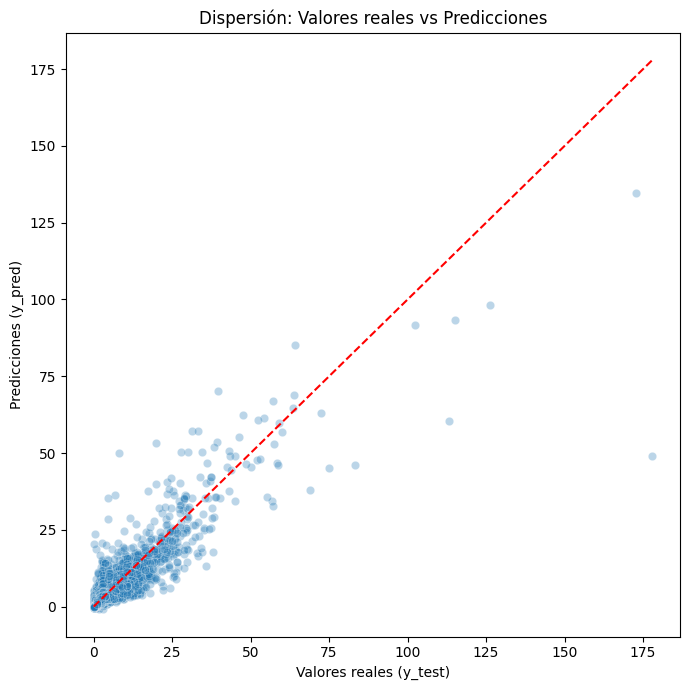

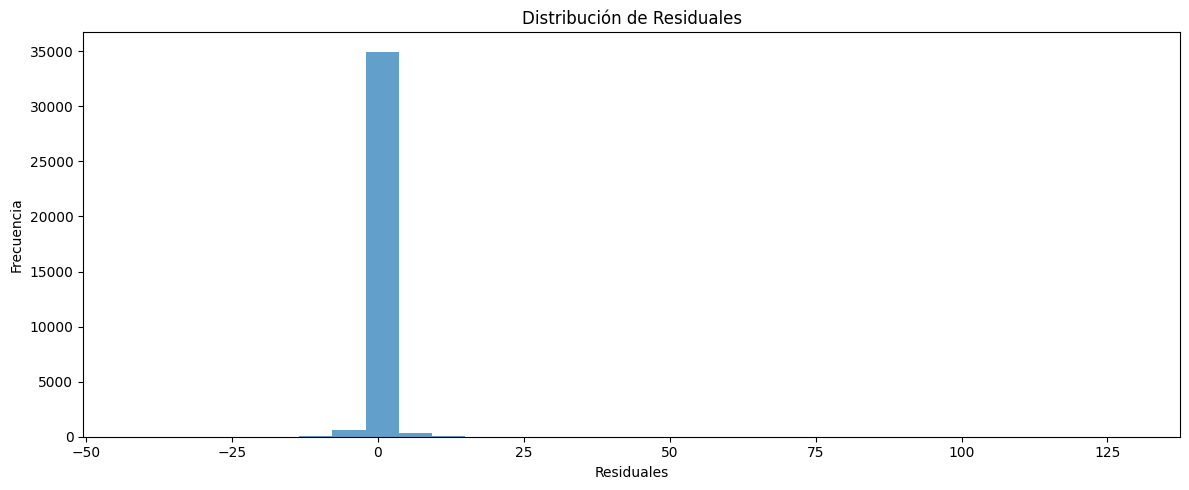

RMSE para quintil 0: 0.238
RMSE para quintil 1: 0.383
RMSE para quintil 2: 0.523
RMSE para quintil 3: 0.661
RMSE para quintil 5: 0.741


In [5]:
# Gráficos de desempeño del modelo

# 1. Gráfico de dispersión: y_test vs y_pred
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Dispersión: Valores reales vs Predicciones")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

# 2. Histograma de los residuos
residuales = y_test - y_pred

# Gráfico de residuales vs valores predichos
plt.figure(figsize=(12, 5))

# Histograma de residuales
plt.hist(residuales, bins=30, alpha=0.7)
plt.xlabel('Residuales')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuales')
plt.tight_layout()
plt.show()

quintil = np.percentile(y_test, [25, 50, 75, 90, 95])
for p in quintil:
    mask = y_test <= p
    rmse_subset = np.sqrt(mean_squared_error(y_test[mask], y_pred[mask]))
    print(f"RMSE para quintil {p:.0f}: {rmse_subset:.3f}")


In [6]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    mejor_modelo, X, y, cv=5, scoring='neg_root_mean_squared_error'
)


c:\Users\nicoa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\nicoa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\nicoa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\nicoa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zer

Promedios por cluster:
         Prom. Hembras Ovígeras  Prom. Adultos Móviles  Prom. Juveniles  \
cluster                                                                   
0                      0.275114               0.344126         0.353752   
1                     18.420283              21.326354        29.509033   
2                      1.454608               1.824101         2.402691   

         Temperatura  Salinidad  
cluster                          
0           9.810000  19.043586  
1          11.257681  30.430157  
2          11.282976  30.501415  


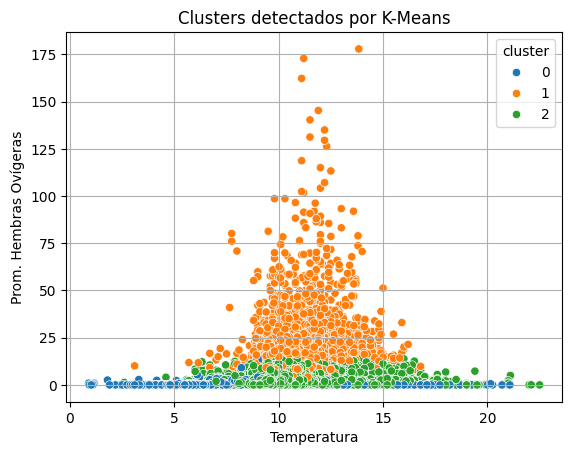

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# 1. Selección de variables
# ------------------------------
features = [
    'Prom. Hembras Ovígeras',
    'Prom. Adultos Móviles',
    'Prom. Juveniles',
    'Temperatura',
    'Salinidad'
]

# Asegúrate de tener tu DataFrame `df` cargado previamente (por ejemplo con pd.read_excel)
X = df[features].dropna()

# ------------------------------
# 2. Escalado de datos
# ------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------
# 3. Aplicar K-Means
# ------------------------------
# Puedes elegir el número de clusters (por ejemplo, 3)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# ------------------------------
# 4. Crear DataFrame con etiquetas de cluster
# ------------------------------
df_clusters = X.copy()
df_clusters['cluster'] = cluster_labels

# ------------------------------
# 5. Análisis: promedio por cluster
# ------------------------------
print("Promedios por cluster:")
print(df_clusters.groupby('cluster').mean())

# ------------------------------
# 6. Visualización
# ------------------------------
sns.scatterplot(
    data=df_clusters,
    x='Temperatura',
    y='Prom. Hembras Ovígeras',
    hue='cluster',
    palette='tab10'
)
plt.title("Clusters detectados por K-Means")
plt.grid(True)
plt.show()

In [8]:
# Mostrar número de muestras por cluster (incluyendo ruido -1)
print(df_clusters['cluster'].value_counts())

# Calcular medias de cada variable por cluster (excepto el ruido si lo deseas)
df_summary = df_clusters[df_clusters['cluster'] != -1].groupby('cluster').mean()

print("\nPromedios por cluster (sin ruido):")
print(df_summary)
df.loc[df_clusters.index, 'cluster'] = cluster_labels

cluster
2    141736
0     35267
1      3172
Name: count, dtype: int64

Promedios por cluster (sin ruido):
         Prom. Hembras Ovígeras  Prom. Adultos Móviles  Prom. Juveniles  \
cluster                                                                   
0                      0.275114               0.344126         0.353752   
1                     18.420283              21.326354        29.509033   
2                      1.454608               1.824101         2.402691   

         Temperatura  Salinidad  
cluster                          
0           9.810000  19.043586  
1          11.257681  30.430157  
2          11.282976  30.501415  


Fitting 3 folds for each of 64 candidates, totalling 192 fits

✅ Modelo con cluster_kmeans
Mejores parámetros: {'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 6, 'regressor__min_child_weight': 2, 'regressor__n_estimators': 300, 'regressor__reg_alpha': 0, 'regressor__reg_lambda': 1, 'regressor__subsample': 0.8}
📊 RMSE: 1.511
📈 R²: 0.827

📌 Modelo sin cluster_kmeans:
📊 RMSE: 1.519
📈 R²: 0.825


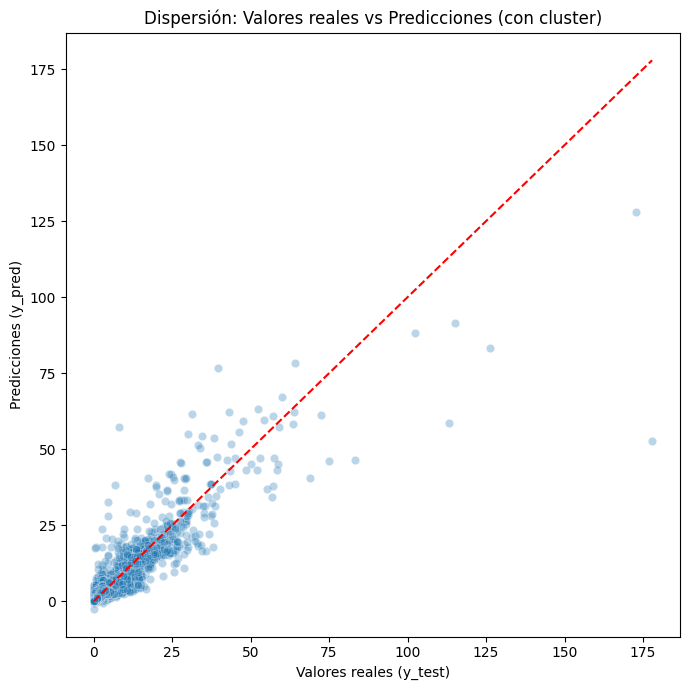

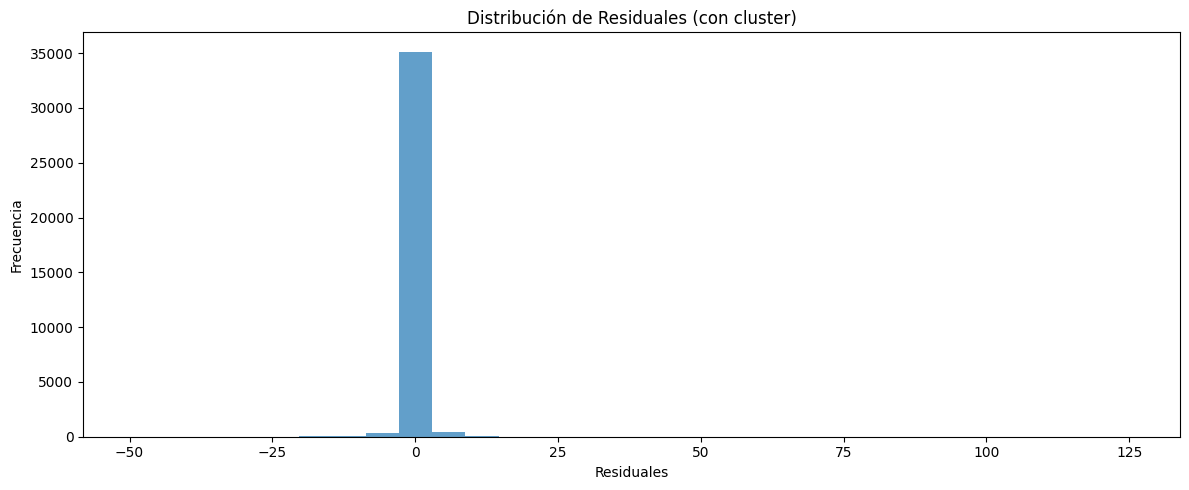


📈 RMSE por tramos del target (quintiles):
   - RMSE para y <= 0: 0.135
   - RMSE para y <= 1: 0.339
   - RMSE para y <= 2: 0.492
   - RMSE para y <= 3: 0.617
   - RMSE para y <= 5: 0.694


In [ ]:
#MODELO MEJORADO CON KMEANS
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns


#  1. Crear variable cluster_kmeans

cluster_features = [
    'Prom. Hembras Ovígeras',
    'Prom. Adultos Móviles',
    'Prom. Juveniles',
    'Temperatura',
    'Salinidad'
]

df_cluster = df[cluster_features].dropna()
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df_cluster)

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster)

df.loc[df_cluster.index, 'cluster_kmeans'] = cluster_labels
df['cluster_kmeans'] = df['cluster_kmeans'].astype('Int64')


#  2. GridSearchCV con cluster como feature

target = 'Prom. Hembras Ovígeras'
features = [
    'Prom. Juveniles',
    'Prom. Adultos Móviles',
    'Temperatura',
    'Salinidad',
    'Región',
    'Especie',
    'ACS',
    'semana',
    'Año',
    'cluster_kmeans'
]

X = df[features].dropna()
y = df.loc[X.index, target]

cat_vars = ['Región', 'Especie', 'ACS', 'cluster_kmeans']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), cat_vars)
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 300],
    'regressor__learning_rate': [0.01, 0.05],
    'regressor__max_depth': [4, 6],
    'regressor__subsample': [0.8],
    'regressor__colsample_bytree': [0.8],
    'regressor__gamma': [0, 1],
    'regressor__reg_alpha': [0, 0.1],
    'regressor__reg_lambda': [1],
    'regressor__min_child_weight': [1, 2]
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

y_pred_cluster = grid_search.predict(X_test)
rmse_cluster = np.sqrt(mean_squared_error(y_test, y_pred_cluster))
r2_cluster = r2_score(y_test, y_pred_cluster)

print("\nModelo con cluster_kmeans")
print("Mejores parámetros:", grid_search.best_params_)
print(f" RMSE: {rmse_cluster:.3f}")
print(f" R²: {r2_cluster:.3f}")


#  3. Modelo final con hiperparámetros óptimos (sin cluster_kmeans)

features_sin_cluster = [
    'Prom. Juveniles',
    'Prom. Adultos Móviles',
    'Temperatura',
    'Salinidad',
    'Región',
    'Especie',
    'ACS',
    'semana',
    'Año'
]

X = df[features_sin_cluster]
y = df[target]

cat_vars = ['Región', 'Especie', 'ACS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_vars)
], remainder='passthrough')

mejores_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 1,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'min_child_weight': 2,
    'random_state': 42
}

mejor_modelo = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(**mejores_params))
])

mejor_modelo.fit(X_train, y_train)
y_pred_sin_cluster = mejor_modelo.predict(X_test)

rmse_sin_cluster = np.sqrt(mean_squared_error(y_test, y_pred_sin_cluster))
r2_sin_cluster = r2_score(y_test, y_pred_sin_cluster)

print("\n Modelo sin cluster_kmeans:")
print(f" RMSE: {rmse_sin_cluster:.3f}")
print(f" R²: {r2_sin_cluster:.3f}")

#  4. Gráficos de desempeño del modelo (con cluster)


# y_test vs y_pred
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred_cluster, alpha=0.3)
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Dispersión: Valores reales vs Predicciones (con cluster)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

# Histograma de residuos
residuales = y_test - y_pred_cluster

plt.figure(figsize=(12, 5))
plt.hist(residuales, bins=30, alpha=0.7)
plt.xlabel('Residuales')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuales (con cluster)')
plt.tight_layout()
plt.show()

# RMSE por quintil del target
quintiles = np.percentile(y_test, [25, 50, 75, 90, 95])
print("\n RMSE por tramos del target (quintiles):")
for p in quintiles:
    mask = y_test <= p
    rmse_subset = np.sqrt(mean_squared_error(y_test[mask], y_pred_cluster[mask]))
    print(f"   - RMSE para y <= {p:.0f}: {rmse_subset:.3f}")

In [10]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    mejor_modelo, X, y, cv=5, scoring='neg_root_mean_squared_error'
)

Tamaño de entrenamiento: 14414, RMSE train: 0.486, RMSE val: 2.198
Tamaño de entrenamiento: 46845, RMSE train: 0.599, RMSE val: 2.208
Tamaño de entrenamiento: 79277, RMSE train: 0.644, RMSE val: 1.990
Tamaño de entrenamiento: 111708, RMSE train: 0.697, RMSE val: 1.895
Tamaño de entrenamiento: 144140, RMSE train: 0.740, RMSE val: 1.782


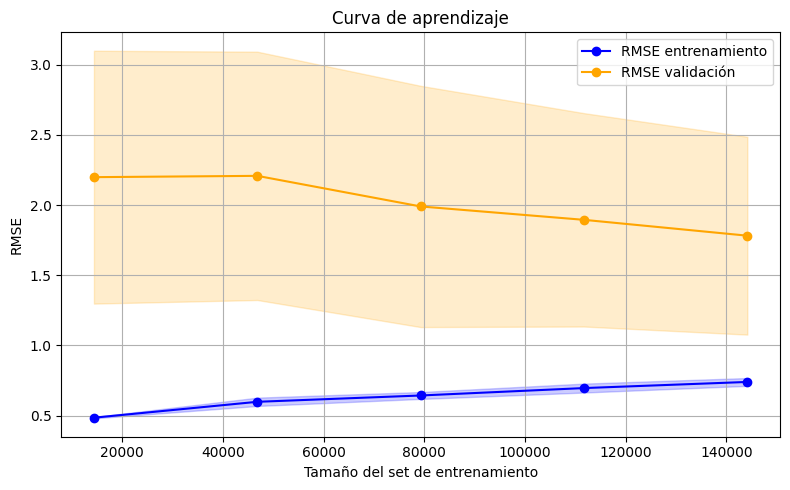

In [11]:


import numpy as np
import matplotlib.pyplot as plt

# Calcular promedios y desviaciones estándar
train_mean = -np.mean(train_scores, axis=1)  # Cambia el signo para RMSE positivo
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Imprimir resultados
for size, tr, te in zip(train_sizes, train_mean, test_mean):
    print(f"Tamaño de entrenamiento: {size}, RMSE train: {tr:.3f}, RMSE val: {te:.3f}")

# Graficar curvas de aprendizaje
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='RMSE entrenamiento')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='orange', label='RMSE validación')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='orange')
plt.xlabel('Tamaño del set de entrenamiento')
plt.ylabel('RMSE')
plt.title('Curva de aprendizaje')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Tamaño de entrenamiento: 14414, RMSE train: 0.486, RMSE val: 2.198
Tamaño de entrenamiento: 46845, RMSE train: 0.599, RMSE val: 2.208
Tamaño de entrenamiento: 79277, RMSE train: 0.644, RMSE val: 1.990
Tamaño de entrenamiento: 111708, RMSE train: 0.697, RMSE val: 1.895
Tamaño de entrenamiento: 144140, RMSE train: 0.740, RMSE val: 1.782


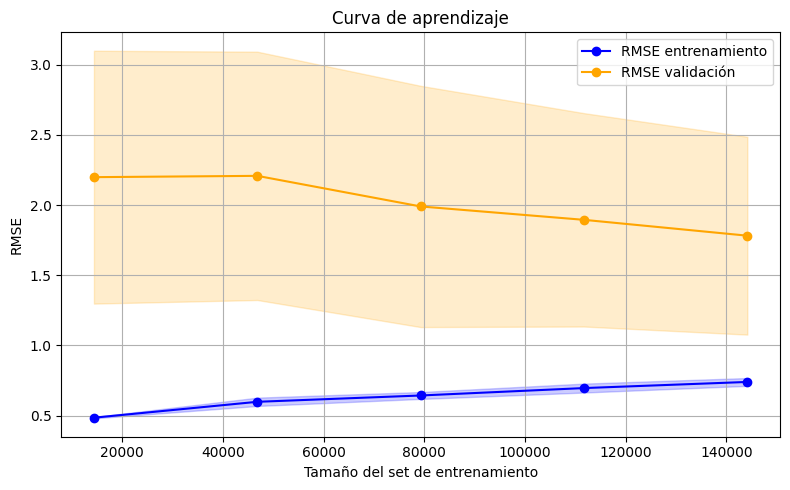

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calcular promedios y desviaciones estándar
train_mean = -np.mean(train_scores, axis=1)  # Cambia el signo para RMSE positivo
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Imprimir resultados
for size, tr, te in zip(train_sizes, train_mean, test_mean):
    print(f"Tamaño de entrenamiento: {size}, RMSE train: {tr:.3f}, RMSE val: {te:.3f}")

# Graficar curvas de aprendizaje
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='RMSE entrenamiento')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='orange', label='RMSE validación')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='orange')
plt.xlabel('Tamaño del set de entrenamiento')
plt.ylabel('RMSE')
plt.title('Curva de aprendizaje')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()